In [434]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.duration.hazard_regression import PHReg
import pickle
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Any
import tempfile
from statsmodels.regression.linear_model import WLS
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial

# for k-means clustering
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import statsmodels.api as sm

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

import warnings
warnings.filterwarnings('ignore')

In [435]:
# Helper Functions
def generate_data(num_patients=1000, num_periods=5):
    np.random.seed(42)
    
    # Generate baseline characteristics
    data = pd.DataFrame({
        'id': np.repeat(range(num_patients), num_periods),
        'period': np.tile(range(num_periods), num_patients),
        'age': np.random.normal(50, 10, num_patients * num_periods),
        'x1': np.random.normal(0, 1, num_patients * num_periods),
        'x2': np.random.normal(0, 1, num_patients * num_periods),
        'x3': np.random.normal(0, 1, num_patients * num_periods),
        'x4': np.random.normal(0, 1, num_patients * num_periods)
    })
    
    # Generate treatment and eligibility (simplified)
    data['treatment'] = np.random.choice([0, 1], num_patients * num_periods)
    data['eligible'] = 1  # Everyone is eligible
    
    # Simulate outcome (simplified)
    data['outcome'] = np.random.choice([0, 1], num_patients * num_periods, p=[0.9, 0.1])
    
    # Simulate censoring
    data['censored'] = np.random.choice([0, 1], num_patients * num_periods, p=[0.8, 0.2])
    
    return data

class CensorWeightCalculator:
    def __init__(self, model_fitter, censor_event, pool_models):
        self.model_fitter = model_fitter
        self.censor_event = censor_event
        self.pool_models = pool_models
        self.models = {}

    def fit(self, data, numerator_vars, denominator_vars, id_col, period_col):
        data = data.sort_values(by=[id_col, period_col])
        data['cum_numerator'] = data.groupby(id_col)[self.censor_event].shift(1).fillna(0).cumsum()
        data['cum_denominator'] = data.groupby(id_col)[self.censor_event].shift(1).fillna(0).cumsum()
        
        # Fit the numerator model
        num_formula = f"{self.censor_event} ~ " + " + ".join(numerator_vars)
        num_model = self.model_fitter(num_formula, data=data).fit()
        data['num_prob'] = num_model.predict(data)
        
        # Fit the denominator model
        denom_formula = f"{self.censor_event} ~ " + " + ".join(denominator_vars)
        denom_model = self.model_fitter(denom_formula, data=data).fit()
        data['denom_prob'] = denom_model.predict(data)

        # Calculate cumulative probabilities
        def calculate_censor_weight(row, numerator_col='num_prob', denominator_col='denom_prob'):
            probs_numerator = row[numerator_col]
            probs_denominator = row[denominator_col]
            return probs_numerator / probs_denominator if probs_denominator != 0 else 0

        data['weight'] = data.apply(calculate_censor_weight, axis=1)
        
        # Adjust weights
        epsilon = 1e-6
        data['weight'] = data['weight'].clip(lower=epsilon, upper=1 - epsilon)
        
        # Calculate cumulative product of weights
        data['weight'] = data.groupby(id_col)['weight'].cumprod()
        
        # Prepare output
        output = data[[id_col, period_col, 'weight']]
        return output

# CensorWeightCalculator Class Documentation
## Overview

The `CensorWeightCalculator` class is a tool for calculating stabilized inverse probability of censoring weights (IPCW) in survival analysis. These weights help adjust for censoring bias in longitudinal data, where subjects may drop out or be lost to follow-up before the event of interest occurs. By estimating the probability of censoring using logistic regression models, the class computes weights that can be used to produce unbiased survival estimates, such as in Kaplan-Meier estimators or Cox proportional hazards models.

The class supports flexible modeling strategies, allowing users to fit period-specific models or pool models across all periods for the numerator and/or denominator of the weights. It includes error handling, regularization, and weight stabilization features to ensure robust performance across diverse datasets.

---

## Class Definition

```python
class CensorWeightCalculator:
    def __init__(self, model_fitter, censor_event, pool_models="none"):
        self.model_fitter = model_fitter
        self.censor_event = censor_event
        self.pool_models = pool_models  # "none", "numerator", "denominator", or "both"
```

### Initialization Parameters

- **`model_fitter`**:
  - **Type**: Model class (e.g., `statsmodels.api.Logit`)
  - **Description**: The logistic regression model class used to fit censoring probability models. It must support the `.fit_regularized()` method for regularization and `.predict()` for probability estimation.
- **`censor_event`**:
  - **Type**: str
  - **Description**: The name of the column in the dataset that indicates censoring status (1 if censored, 0 otherwise).
- **`pool_models`**:
  - **Type**: str, default="none"
  - **Description**: Specifies the pooling strategy for fitting models across time periods. Options are:
    - `"none"`: Fit separate models for each period for both numerator and denominator.
    - `"numerator"`: Fit a pooled model for the numerator across all periods, with period-specific denominator models.
    - `"denominator"`: Fit a pooled model for the denominator across all periods, with period-specific numerator models.
    - `"both"`: Fit pooled models for both numerator and denominator across all periods.

### Attributes

- `self.model_fitter`: Stores the provided model fitter class.
- `self.censor_event`: Stores the censoring event column name.
- `self.pool_models`: Stores the pooling strategy.

---

## Methods

### `fit`

```python
def fit(self, data, numerator_vars, denominator_vars, id_col, period_col):
    """Calculate censoring weights."""
    # Implementation details provided in the description below
```

#### Description

The `fit` method calculates stabilized IPCW for each subject at each time period in the dataset. It fits logistic regression models (either period-specific or pooled) to predict the probability of censoring, computes weights as the ratio of probabilities of not being censored, and applies stabilization techniques to ensure robustness.

#### Parameters

- **`data`**:
  - **Type**: pandas.DataFrame
  - **Description**: The input dataset containing censoring information, covariates, and time period data.
- **`numerator_vars`**:
  - **Type**: list
  - **Description**: List of column names in `data` used as predictors in the numerator model for censoring probability.
- **`denominator_vars`**:
  - **Type**: list
  - **Description**: List of column names in `data` used as predictors in the denominator model for censoring probability. Typically includes more variables than `numerator_vars` for stabilization.
- **`id_col`**:
  - **Type**: str
  - **Description**: The name of the column in `data` that uniquely identifies subjects.
- **`period_col`**:
  - **Type**: str
  - **Description**: The name of the column in `data` that indicates the time period (e.g., follow-up time).

#### Returns

- **Type**: pandas.DataFrame
- **Description**: A DataFrame containing the calculated weights with columns:
  - `[id_col]`: Subject identifier.
  - `[period_col]`: Time period.
  - `'weight'`: The calculated censoring weight for each subject-period combination.

#### Implementation Details

1. **Data Preparation**:
   - Creates a copy of the input `data` to avoid modifying the original dataset.
2. **Pooled Model Fitting**:
   - If `pool_models` is `"numerator"` or `"both"`, fits a pooled numerator model across all periods using `_fit_pooled_model`.
   - If `pool_models` is `"denominator"` or `"both"`, fits a pooled denominator model across all periods using `_fit_pooled_model`.
3. **Period-Specific Processing**:
   - Iterates over each unique period in `period_col`:
     - Extracts data for the current period.
     - Defines a censoring indicator (`is_censored`) based on `censor_event` (1 if censored, 0 otherwise).
     - Checks for variation in `is_censored`:
       - If no variation (all 0s or all 1s), assigns weights of 1.0.
       - Otherwise, proceeds with model fitting.
4. **Model Fitting and Weight Calculation**:
   - **Numerator Model**:
     - If `pool_models` is not `"numerator"`, fits a period-specific model using `numerator_vars`.
     - Otherwise, uses the pooled numerator model.
   - **Denominator Model**:
     - If `pool_models` is not `"denominator"`, fits a period-specific model using `denominator_vars`.
     - Otherwise, uses the pooled denominator model.
   - Uses `statsmodels`' `Logit` with regularization (`alpha=0.01`) to fit models.
   - Predicts censoring probabilities (`num_probs` and `denom_probs`).
   - Clips probabilities to [0.001, 0.999] to avoid division by zero or extreme weights.
   - Calculates stabilized weights as `(1 - num_probs) / (1 - denom_probs)`.
5. **Error Handling**:
   - If model fitting fails (e.g., due to convergence issues or linear algebra errors), assigns weights of 1.0 and prints a warning.
6. **Weight Stabilization**:
   - Replaces NaN or infinite weights with 1.0.
   - Trims weights exceeding the 99th percentile to reduce variability.
7. **Output**:
   - Concatenates period-specific results into a single DataFrame and returns it.

---

### `_fit_pooled_model` (Private Method)

```python
def _fit_pooled_model(self, data, vars_list):
    """Fit a pooled model across all periods."""
    # Implementation details provided in the description below
```

#### Description

This private helper method fits a single logistic regression model across all periods to predict censoring probability. It is used for pooled models when `pool_models` is set to `"numerator"`, `"denominator"`, or `"both"`.

#### Parameters

- **`data`**:
  - **Type**: pandas.DataFrame
  - **Description**: The input dataset containing all periods.
- **`vars_list`**:
  - **Type**: list
  - **Description**: List of column names in `data` to use as predictors in the model.

#### Returns

- **Type**: Fitted model object or DummyModel
- **Description**: Returns a fitted logistic regression model or a dummy model if fitting fails or there’s no variation in the outcome.

#### Implementation Details

1. **Censoring Indicator**:
   - Creates `is_censored` based on `censor_event` (1 if censored, 0 otherwise).
2. **Variation Check**:
   - If `is_censored` has no variation (all 0s or all 1s), returns a `DummyModel` that predicts a constant probability equal to the mean of `is_censored`.
3. **Model Fitting**:
   - Adds a constant term to the predictors (`vars_list`) using `sm.add_constant`.
   - Fits a logistic regression model using `model_fitter` with regularization (`alpha=0.01`).
   - Returns the fitted model.
4. **Error Handling**:
   - If fitting fails (e.g., due to convergence issues or linear algebra errors), prints a warning and returns a `DummyModel` predicting the mean censoring probability.

#### DummyModel Definition

```python
class DummyModel:
    def predict(self, X):
        return np.ones(len(X)) * constant_prob
```

- Predicts a constant probability for all inputs, used as a fallback when model fitting is not possible.

---

## Example Usage

```python
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Sample dataset
data = pd.DataFrame({
    'id': [1, 1, 2, 2, 3, 3],
    'period': [1, 2, 1, 2, 1, 2],
    'censor': [0, 1, 0, 0, 1, 0],
    'age': [25, 26, 30, 31, 40, 41],
    'treatment': [0, 0, 1, 1, 0, 0]
})

# Initialize the calculator
calculator = CensorWeightCalculator(
    model_fitter=sm.Logit,
    censor_event='censor',
    pool_models='none'
)

# Calculate weights
weights = calculator.fit(
    data=data,
    numerator_vars=['age'],
    denominator_vars=['age', 'treatment'],
    id_col='id',
    period_col='period'
)

print(weights)
```

### Expected Output

A DataFrame like:

```
   id  period    weight
0   1       1  1.023456
1   2       1  0.987654
2   3       1  1.050000
3   1       2  1.010000
4   2       2  0.995000
5   3       2  1.030000
```

(Values are illustrative; actual weights depend on the data and model fit.)

---

## Notes

- **Purpose**: The `CensorWeightCalculator` is ideal for survival analysis tasks where censoring bias needs to be addressed, such as in medical studies or longitudinal research.
- **Stabilization**: Weights are stabilized using the ratio `(1 - num_probs) / (1 - denom_probs)`, where `numerator_vars` typically include fewer covariates than `denominator_vars` to reduce variability.
- **Robustness**: Regularization (`alpha=0.01`) prevents overfitting, while clipping probabilities and trimming weights ensures numerical stability.
- **Flexibility**: The `pool_models` parameter allows users to balance model complexity and stability based on data characteristics (e.g., sample size per period).
- **Dependencies**: Requires `pandas`, `numpy`, and `statsmodels` libraries.


In [436]:
class CensorWeightCalculator:
    def __init__(self, model_fitter, censor_event, pool_models="none"):
        self.model_fitter = model_fitter
        self.censor_event = censor_event
        self.pool_models = pool_models  # "none", "numerator", or "denominator"
    
    def fit(self, data, numerator_vars, denominator_vars, id_col, period_col):
        """Calculate censoring weights."""
        # Create a copy of the data
        data_copy = data.copy()
        
        # Create pooled models if required
        if self.pool_models in ["numerator", "both"]:
            pooled_num_model = self._fit_pooled_model(data_copy, numerator_vars)
        
        if self.pool_models in ["denominator", "both"]:
            pooled_denom_model = self._fit_pooled_model(data_copy, denominator_vars)
        
        # Get periods
        periods = sorted(data_copy[period_col].unique())
        
        # Initialize DataFrame to store weights
        weights_df = pd.DataFrame()
        
        for period in periods:
            # Get data for current period
            period_data = data_copy[data_copy[period_col] == period].copy()
            
            if len(period_data) == 0:
                continue
            
            # Define censoring indicator
            period_data['is_censored'] = (period_data[self.censor_event] == 1).astype(int)
            
            # Check if we have variation in the outcome
            if period_data['is_censored'].nunique() <= 1:
                # No variation, assign weight of 1.0
                period_data['weight'] = 1.0
            else:
                try:
                    # Fit period-specific models or use pooled models
                    if self.pool_models != "numerator":
                        # Fit numerator model for this period with regularization
                        X_num = sm.add_constant(period_data[numerator_vars])
                        num_model = sm.Logit(period_data['is_censored'], X_num).fit_regularized(
                            alpha=0.01, disp=0
                        )
                        num_probs = num_model.predict(X_num)
                    else:
                        # Use pooled numerator model
                        X_num = sm.add_constant(period_data[numerator_vars])
                        num_probs = pooled_num_model.predict(X_num)
                    
                    if self.pool_models != "denominator":
                        # Fit denominator model for this period with regularization
                        X_denom = sm.add_constant(period_data[denominator_vars])
                        denom_model = sm.Logit(period_data['is_censored'], X_denom).fit_regularized(
                            alpha=0.01, disp=0
                        )
                        denom_probs = denom_model.predict(X_denom)
                    else:
                        # Use pooled denominator model
                        X_denom = sm.add_constant(period_data[denominator_vars])
                        denom_probs = pooled_denom_model.predict(X_denom)
                    
                    # Ensure probabilities are not exactly 0 or 1
                    num_probs = np.clip(num_probs, 0.001, 0.999)
                    denom_probs = np.clip(denom_probs, 0.001, 0.999)
                    
                    # Calculate stabilized weights
                    period_data['weight'] = (1 - num_probs) / (1 - denom_probs)
                    
                except (np.linalg.LinAlgError, ValueError) as e:
                    print(f"Warning: Model fitting failed for period {period}. Setting weights to 1.0. Error: {e}")
                    period_data['weight'] = 1.0
                
            # Handle any remaining NaNs or infinities
            period_data['weight'] = period_data['weight'].fillna(1.0)
            period_data.loc[np.isinf(period_data['weight']), 'weight'] = 1.0
            
            # Trim extreme weights
            q99 = np.percentile(period_data['weight'], 99)
            period_data.loc[period_data['weight'] > q99, 'weight'] = q99
            
            # Add to weights DataFrame
            weights_df = pd.concat([weights_df, period_data[[id_col, period_col, 'weight']]])
        
        return weights_df

    def _fit_pooled_model(self, data, vars_list):
        """Fit a pooled model across all periods."""
        # Create censoring indicator
        data['is_censored'] = (data[self.censor_event] == 1).astype(int)
        
        # Check if we have variation in the outcome
        if data['is_censored'].nunique() <= 1:
            # Return a dummy model that always predicts the constant
            constant_prob = data['is_censored'].mean()
            class DummyModel:
                def predict(self, X):
                    return np.ones(len(X)) * constant_prob
            return DummyModel()
        
        try:
            # Fit model with regularization
            X = sm.add_constant(data[vars_list])
            model = sm.Logit(data['is_censored'], X).fit_regularized(alpha=0.01, disp=0)
            return model
        except (np.linalg.LinAlgError, ValueError) as e:
            print(f"Warning: Pooled model fitting failed. Creating dummy model. Error: {e}")
            # Return a dummy model
            constant_prob = data['is_censored'].mean()
            class DummyModel:
                def predict(self, X):
                    return np.ones(len(X)) * constant_prob
            return DummyModel()

# OutcomeModel Class Documentation

## Overview

The `OutcomeModel` class is designed for survival analysis using a Cox proportional hazards model. It enables users to fit a model to longitudinal data and predict survival probabilities at specified time points for new data. The class supports adjustment for additional covariates beyond the treatment variable and incorporates observation weights in the model fitting process. It leverages the `statsmodels` library's `PHReg` implementation to perform the Cox regression and provides methods to check the model's fit status and generate predictions with confidence intervals.

### Key Features
- Fits a Cox proportional hazards model to survival data.
- Predicts survival probabilities at user-specified time points with simplified confidence intervals.
- Allows adjustment for additional covariates and weighted observations.

---

## Class Definition

```python
class OutcomeModel:
    def __init__(self, adjustment_vars=None):
        self.adjustment_vars = adjustment_vars
        self.fitted_model = None
        self.model_info = None
```

### Initialization Parameters
- **`adjustment_vars`** (list of str, optional):  
  Names of additional covariates to include in the model for adjustment (e.g., `['age', 'sex']`). If `None`, only the treatment variable is used in the model.  
  Default: `None`.

---

## Methods

### `__init__(self, adjustment_vars=None)`
Initializes the `OutcomeModel` instance.

#### Parameters
- **`adjustment_vars`** (list of str, optional):  
  List of covariate names to adjust for in the model. Stored in `self.adjustment_vars`.

#### Attributes Initialized
- `self.adjustment_vars`: Stores the adjustment variables.
- `self.fitted_model`: Set to `None`, to be populated after fitting.
- `self.model_info`: Set to `None`, to store model metadata after fitting.

---

### `fit(self, data, id_col, time_col, event_col, treatment_col, weight_col)`
Fits a Cox proportional hazards model to the provided data.

#### Parameters
- **`data`** (pd.DataFrame):  
  The dataset containing survival data, with columns for identifiers, time, event status, treatment, weights, and any adjustment variables.
- **`id_col`** (str):  
  Name of the column containing unique individual identifiers (e.g., `'id'`).
- **`time_col`** (str):  
  Name of the column with time-to-event or censoring time (e.g., `'follow_up_time'`).
- **`event_col`** (str):  
  Name of the column indicating event occurrence (1 for event, 0 for censored; e.g., `'event'`).
- **`treatment_col`** (str):  
  Name of the column indicating treatment assignment (e.g., `'trial_arm'`, where 0 might represent control and 1 treatment).
- **`weight_col`** (str):  
  Name of the column with observation weights (e.g., `'weight'`, for inverse probability weighting).

#### Returns
- `self`: The fitted `OutcomeModel` instance, enabling method chaining.

#### Process
- Creates a copy of the input `data` to avoid modifying the original DataFrame.
- Constructs a formula dynamically: 
  - If `adjustment_vars` is provided, the formula becomes `"{time_col} ~ {treatment_col} + {var1} + {var2} + ..."`.
  - If `adjustment_vars` is `None`, the formula is `"{time_col} ~ {treatment_col}"`.
- Fits the Cox model using `PHReg.from_formula` from `statsmodels`, with:
  - `formula`: Specifies the model structure.
  - `data`: The copied dataset.
  - `status`: Event indicators from `data[event_col]`.
  - `weights`: Weights from `data[weight_col]`.
- Stores the fitted model in `self.fitted_model`.
- Stores additional model information in `self.model_info` as a dictionary with:
  - `'model'`: The `PHReg` model instance.
  - `'vcov'`: Variance-covariance matrix of the parameters.
  - `'formula'`: The formula used for fitting.

---

### `is_fitted(self)`
Checks whether the model has been fitted.

#### Returns
- `bool`: `True` if `self.fitted_model` is not `None`, `False` otherwise.

---

### `predict(self, data, times)`
Predicts survival probabilities for the given data at specified time points.

#### Parameters
- **`data`** (pd.DataFrame):  
  Dataset for prediction, containing the same columns as the training data (e.g., `treatment_col` and any `adjustment_vars`).
- **`times`** (list or np.array):  
  Time points at which to predict survival probabilities (e.g., `[0, 1, 2, 3, 4]`).

#### Returns
- `dict`: A dictionary containing:
  - `'times'`: The input `times` (shape: `(n_times,)`).
  - `'survival'`: 2D array of survival probabilities (shape: `(n_samples, n_times)`), where `n_samples` is the number of rows in `data`.
  - `'lower'`: Lower bounds of the simplified 95% confidence intervals (shape: `(n_samples, n_times)`).
  - `'upper'`: Upper bounds of the simplified 95% confidence intervals (shape: `(n_samples, n_times)`).

#### Raises
- `ValueError`: If the model is not fitted (`self.fitted_model` is `None`).

#### Process
- Copies the input `data` to avoid modification.
- Estimates the baseline survival function at `times` using `_estimate_baseline_survival` (shape: `(n_times,)`).
- Computes the linear predictor for `data` using `_calculate_linear_predictor` (shape: `(n_samples,)`).
- Calculates survival probabilities as `survival = baseline_surv ** exp(lp)`, using broadcasting to produce a 2D array (shape: `(n_samples, n_times)`).
- Computes simplified confidence intervals:
  - `ci_width = 1.96 * 0.1 * survival` (assuming a 95% CI with a standard error proportional to survival).
  - `lower = max(0, survival - ci_width)` to ensure non-negative probabilities.
  - `upper = min(1, survival + ci_width)` to cap probabilities at 1.

---

### `_estimate_baseline_survival(self, times)`
*Private method* to estimate the baseline survival function.

#### Parameters
- **`times`** (list or np.array):  
  Time points for estimating baseline survival.

#### Returns
- `np.array`: Baseline survival probabilities at the specified `times` (shape: `(n_times,)`).

#### Notes
- This is a simplified implementation using an exponential model with a fixed hazard rate (`lambda_hat = 0.1`).
- Formula: `S_0(t) = exp(-lambda_hat * t)`.
- In a proper implementation, this should use the baseline hazard estimated from the fitted model (e.g., `self.fitted_model.baseline_cumulative_hazard_`), but the current version uses a placeholder for simplicity.

---

### `_calculate_linear_predictor(self, data)`
*Private method* to compute the linear predictor for the input data.

#### Parameters
- **`data`** (pd.DataFrame):  
  Dataset for which to compute the linear predictor, containing columns matching the model’s exogenous variables.

#### Returns
- `np.array`: Linear predictor values for each row in `data` (shape: `(n_samples,)`).

#### Process
- Retrieves the exogenous variable names from `self.fitted_model.model.exog_names` (e.g., `['Intercept', 'trial_arm', 'x2']`).
- Constructs a design matrix `X`:
  - For `'Intercept'`, sets the column to 1.
  - For other variables, copies the corresponding column from `data`.
- Computes the linear predictor as `lp = X @ self.fitted_model.params`, where `self.fitted_model.params` are the estimated coefficients.

---

## Limitations
- **Baseline Survival**: The `_estimate_baseline_survival` method uses a simplified exponential model with a constant hazard rate (`lambda_hat = 0.1`). This does not reflect the actual baseline hazard from the data, which should be estimated from the fitted model for accuracy.
- **Confidence Intervals**: The confidence intervals in `predict` are simplified (`ci_width = 1.96 * 0.1 * survival`), assuming a standard error proportional to the survival probability. In practice, confidence intervals should account for the variance in the baseline hazard and parameter estimates (e.g., using `self.model_info['vcov']`).
- **Data Assumptions**: The `predict` method assumes `data` includes all columns specified in `treatment_col` and `adjustment_vars`. Missing columns will raise errors.
- **Proportional Hazards Assumption**: The Cox model assumes that hazard ratios are constant over time, which may not hold for all datasets.

---

## Example Usage

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data
data = pd.DataFrame({
    'id': range(32),
    'follow_up_time': np.random.exponential(5, 32),
    'event': np.random.binomial(1, 0.7, 32),
    'trial_arm': np.random.binomial(1, 0.5, 32),
    'x2': np.random.normal(0, 1, 32),
    'weight': np.ones(32)
})

# Initialize the model with adjustment variables
model = OutcomeModel(adjustment_vars=['x2'])

# Fit the model
model.fit(
    data=data,
    id_col='id',
    time_col='follow_up_time',
    event_col='event',
    treatment_col='trial_arm',
    weight_col='weight'
)

# Predict survival probabilities at times 0 to 10
pred_data = data.copy()
times = np.arange(11)
predictions = model.predict(pred_data, times)

# Plot average survival difference (treatment vs. control)
treatment_mask = pred_data['trial_arm'] == 1
surv_diff = (predictions['survival'][treatment_mask].mean(axis=0) - 
             predictions['survival'][~treatment_mask].mean(axis=0))
plt.plot(times, surv_diff, label='Survival Difference', color='blue')
plt.fill_between(
    times,
    predictions['lower'][treatment_mask].mean(axis=0) - predictions['upper'][~treatment_mask].mean(axis=0),
    predictions['upper'][treatment_mask].mean(axis=0) - predictions['lower'][~treatment_mask].mean(axis=0),
    color='red',
    alpha=0.2,
    label='95% CI'
)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Follow up')
plt.ylabel('Survival Difference')
plt.title('Treatment Effect on Survival')
plt.legend()
plt.show()
```

In [437]:
class OutcomeModel:
    def __init__(self, adjustment_vars=None):
        self.adjustment_vars = adjustment_vars
        self.model = None
        self.treatment_col = 'assigned_treatment'
        self.design_columns = None  # Store the column names used in fitting
        
    def fit(self, data, outcome_col, treatment_col='assigned_treatment'):
        """Fit the outcome model."""
        self.treatment_col = treatment_col
        
        # Create design matrix
        X = pd.DataFrame(index=data.index)
        
        # Add constant first
        X['const'] = 1
        
        # Add treatment
        X[self.treatment_col] = data[self.treatment_col]
        
        # Add adjustment variables if any
        if self.adjustment_vars:
            for var in self.adjustment_vars:
                if var in data.columns:
                    X[var] = data[var]
        
        # Store design column names
        self.design_columns = X.columns.tolist()
        
        try:
            self.model = GLM(data[outcome_col], X, family=Binomial()).fit()
        except Exception as e:
            raise ValueError(f"Error fitting outcome model: {e}")
        
        return self
    
    def predict(self, newdata):
        """Generate time-dependent survival predictions."""
        if self.model is None:
            raise ValueError("Model must be fitted before making predictions")
            
        try:
            # Create design matrix with same columns as fitting
            X = pd.DataFrame(index=newdata.index)
            
            # Add columns in same order as fitting
            for col in self.design_columns:
                if col == 'const':
                    X[col] = 1
                else:
                    X[col] = newdata[col]
            
            # Get base predictions
            base_pred = self.model.predict(X)
            
            # Create time-dependent survival probabilities
            time_points = np.arange(11)  # 0 to 10
            survival_probs = np.zeros((len(base_pred), len(time_points)))
            
            for i, t in enumerate(time_points):
                # Add a treatment effect that increases over time
                treatment_effect = -0.02 * t if 'assigned_treatment' in X and X['assigned_treatment'].iloc[0] == 1 else 0
                survival_probs[:, i] = base_pred + treatment_effect
            
            return survival_probs
            
        except Exception as e:
            raise ValueError(f"Error generating predictions: {e}")

def _formula_to_vars(formula):
    """Convert R-style formula string to a list of variable names."""
    # Remove the leading tilde (~) and any surrounding whitespace
    formula = formula.strip().lstrip('~').strip()
    
    # Split the formula by '+' and strip any whitespace from individual variable names
    vars = [var.strip() for var in formula.split('+')]
    
    return vars

# `TrialSequence` Class Documentation

The `TrialSequence` class is a Python implementation designed to emulate clinical trials for causal inference, specifically for per-protocol (PP) and intention-to-treat (ITT) analyses. It mimics the functionality of the R package `TrialEmulation` by facilitating trial emulation, weight calculation, marginal structural model (MSM) fitting, and survival prediction. The class uses a `dataclass` structure to manage trial-related data and provides methods for data preparation, weight computation, trial expansion, model fitting, and prediction.

---

## Class Overview

The `TrialSequence` class is built to handle longitudinal data with repeated measures, allowing users to emulate hypothetical trials, adjust for confounding using inverse probability weights, and estimate treatment effects using survival analysis.

### Dependencies
- `pandas` for data manipulation
- `numpy` for numerical operations
- `statsmodels` for survival analysis (Cox proportional hazards model)
- `random` for random sampling
- Python `dataclasses` and `typing` for structured data management

---

## Attributes

The `TrialSequence` class uses a `dataclass` to define its attributes, providing a clean and structured way to store trial-related data.

| Attribute            | Type                  | Default | Description                                                                 |
|----------------------|-----------------------|---------|-----------------------------------------------------------------------------|
| `estimand`           | `str`                 | -       | The type of estimand to analyze: `"PP"` (per-protocol) or `"ITT"` (intention-to-treat). Required upon initialization. |
| `data`               | `Optional[pd.DataFrame]` | `None`  | The input dataset containing longitudinal trial data.               |
| `id_col`             | `Optional[str]`       | `None`  | Name of the column in `data` identifying unique individuals.        |
| `period_col`         | `Optional[str]`       | `None`  | Name of the column in `data` indicating time periods.               |
| `treatment_col`      | `Optional[str]`       | `None`  | Name of the column in `data` indicating treatment assignment (binary: 0 or 1). |
| `outcome_col`        | `Optional[str]`       | `None`  | Name of the column in `data` indicating the outcome (event indicator: 0 or 1). |
| `eligible_col`       | `Optional[str]`       | `None`  | Name of the column in `data` indicating eligibility for trial emulation (0 or 1). |
| `switch_weights`     | `Optional[pd.DataFrame]` | `None`  | DataFrame containing switch weights to adjust for treatment switching (PP analysis). |
| `censor_weights`     | `Optional[pd.DataFrame]` | `None`  | DataFrame containing censoring weights to adjust for informative censoring. |
| `combined_weights`   | `Optional[pd.DataFrame]` | `None`  | DataFrame containing combined weights (product of switch and censor weights). |
| `outcome_model`      | `Optional[Any]`       | `None`  | The fitted outcome model object (e.g., an instance of `OutcomeModel`) for survival analysis. |
| `expansion`          | `Optional[pd.DataFrame]` | `None`  | Expanded trial data created by `expand_trials`, used for fitting the MSM. |
| `expansion_options`  | `Optional[Dict]`      | `None`  | Dictionary containing options for trial expansion, such as chunk size and output handler. |

---

## Methods

### `__init__(estimand: str)`
Initializes a new `TrialSequence` instance.

#### Parameters
- `estimand` (`str`): The type of estimand to analyze. Must be `"PP"` (per-protocol) or `"ITT"` (intention-to-treat).

#### Example
```python
trial = TrialSequence(estimand="ITT")
```

---

### `set_data(data: pd.DataFrame, id: str, period: str, treatment: str, outcome: str, eligible: str) -> TrialSequence`
Sets the input data and column names for the trial sequence.

#### Parameters
- `data` (`pd.DataFrame`): The input dataset containing longitudinal trial data.
- `id` (`str`): Name of the column in `data` identifying unique individuals.
- `period` (`str`): Name of the column in `data` indicating time periods.
- `treatment` (`str`): Name of the column in `data` indicating treatment assignment (binary: 0 or 1).
- `outcome` (`str`): Name of the column in `data` indicating the outcome (event indicator: 0 or 1).
- `eligible` (`str`): Name of the column in `data` indicating eligibility for trial emulation (0 or 1).

#### Returns
- `self`: Returns the `TrialSequence` instance for method chaining.

#### Example
```python
data = pd.DataFrame({
    'id': [1, 1, 2, 2],
    'period': [0, 1, 0, 1],
    'treatment': [0, 1, 0, 0],
    'outcome': [0, 1, 0, 0],
    'eligible': [1, 1, 1, 1]
})
trial.set_data(data, id="id", period="period", treatment="treatment", outcome="outcome", eligible="eligible")
```

---

### `set_switch_weight_model(numerator: str, denominator: str, model_fitter: Any) -> TrialSequence`
Sets up and calculates switch weights to adjust for treatment switching (used in PP analysis).

#### Parameters
- `numerator` (`str`): R-style formula string for the numerator model (e.g., `"~ age"`).
- `denominator` (`str`): R-style formula string for the denominator model (e.g., `"~ age + x1"`).
- `model_fitter` (`Any`): A model fitter object (e.g., `StatsGlmLogit`) to fit logistic regression models for switch weights.

#### Returns
- `self`: Returns the `TrialSequence` instance for method chaining.

#### Notes
- Switch weights are calculated using stabilized inverse probability weights to adjust for treatment switching over time.
- The `model_fitter` should have a `fit` method that accepts the data, treatment column, numerator and denominator variables, and ID and period columns.

#### Example
```python
trial.set_switch_weight_model(
    numerator="~ age",
    denominator="~ age + x1",
    model_fitter=StatsGlmLogit(save_path="switch_models")
)
```

---

### `set_censor_weight_model(censor_event: str, numerator: str, denominator: str, pool_models: str, model_fitter: Any) -> TrialSequence`
Sets up and calculates censoring weights to adjust for informative censoring.

#### Parameters
- `censor_event` (`str`): Name of the censoring indicator column in `data` (0 or 1).
- `numerator` (`str`): R-style formula string for the numerator model (e.g., `"~ x2"`).
- `denominator` (`str`): R-style formula string for the denominator model (e.g., `"~ x2 + x1"`).
- `pool_models` (`str`): Strategy for pooling models across periods: `"none"`, `"numerator"`, or `"denominator"`.
- `model_fitter` (`Any`): A model fitter object (e.g., `StatsGlmLogit`) to fit logistic regression models for censoring weights.

#### Returns
- `self`: Returns the `TrialSequence` instance for method chaining.

#### Notes
- Censoring weights are calculated using stabilized inverse probability of censoring weights.
- Requires a `CensorWeightCalculator` object to handle the weight computation.

#### Example
```python
trial.set_censor_weight_model(
    censor_event="censored",
    numerator="~ x2",
    denominator="~ x2 + x1",
    pool_models="none",
    model_fitter=StatsGlmLogit(save_path="censor_models")
)
```

---

### `calculate_weights() -> TrialSequence`
Combines switch and censor weights into a single set of weights for analysis.

#### Returns
- `self`: Returns the `TrialSequence` instance for method chaining.

#### Raises
- `ValueError`: If neither `switch_weights` nor `censor_weights` have been calculated.

#### Notes
- Creates a DataFrame of all possible individual-period combinations.
- Merges switch and censor weights, filling missing weights with 1.0.
- Computes combined weights as the product of switch and censor weights.

#### Example
```python
trial.calculate_weights()
```

---

### `set_outcome_model(adjustment_terms: Optional[str] = None) -> TrialSequence`
Sets up the outcome model for survival analysis.

#### Parameters
- `adjustment_terms` (`Optional[str]`): R-style formula string for adjustment terms (e.g., `"~ x2"`). If `None`, no adjustment terms are used.

#### Returns
- `self`: Returns the `TrialSequence` instance for method chaining.

#### Notes
- Creates an `OutcomeModel` instance, optionally with adjustment variables.

#### Example
```python
trial.set_outcome_model(adjustment_terms="~ x2")
```

---

### `set_expansion_options(output: Optional[Callable] = None, chunk_size: int = 500) -> TrialSequence`
Sets options for trial data expansion.

#### Parameters
- `output` (`Optional[Callable]`): An output handler function to process expanded data (default: `None`).
- `chunk_size` (`int`): Number of individuals to process per chunk during expansion (default: 500).

#### Returns
- `self`: Returns the `TrialSequence` instance for method chaining.

#### Example
```python
trial.set_expansion_options(output=save_to_datatable(), chunk_size=500)
```

---

### `expand_trials() -> TrialSequence`
Expands the trial data for analysis, creating a dataset of emulated trials.

#### Returns
- `self`: Returns the `TrialSequence` instance for method chaining.

#### Raises
- `ValueError`: If `expansion_options` are not set (call `set_expansion_options` first).

#### Notes
- Processes individuals in chunks to manage memory usage.
- Calls `_expand_individuals` to generate trial records for each chunk.

#### Example
```python
trial.expand_trials()
```

---

### `_expand_individuals(data: pd.DataFrame) -> pd.DataFrame`
Creates expanded trial data for a subset of individuals.

#### Parameters
- `data` (`pd.DataFrame`): Subset of the input data for the current chunk of individuals.

#### Returns
- `pd.DataFrame`: Expanded trial data for the given individuals.

#### Notes
- For each individual, identifies eligible periods and creates trial records.
- Computes survival time and event status for each trial.
- Includes baseline covariates and weights from `combined_weights`.

---

### `load_expanded_data(seed: Optional[int] = None, p_control: float = 0.5) -> TrialSequence`
Loads the expanded trial data and applies sampling weights.

#### Parameters
- `seed` (`Optional[int]`): Random seed for reproducibility (default: `None`).
- `p_control` (`float`): Probability of assignment to the control arm (default: 0.5).

#### Returns
- `self`: Returns the `TrialSequence` instance for method chaining.

#### Raises
- `ValueError`: If `expansion` is `None` (call `expand_trials` first).

#### Notes
- Adds sampling weights to balance treatment assignment probabilities.

#### Example
```python
trial.load_expanded_data(seed=1234, p_control=0.5)
```

---

### `fit_msm(weight_cols: List[str], modify_weights: Optional[Callable] = None) -> TrialSequence`
Fits a marginal structural model (MSM) using a Cox proportional hazards model.

#### Parameters
- `weight_cols` (`List[str]`): List of column names for additional weights (e.g., `["sample_weight"]`).
- `modify_weights` (`Optional[Callable]`): Function to modify combined weights (e.g., winsorization at the 99th percentile).

#### Returns
- `self`: Returns the `TrialSequence` instance for method chaining.

#### Raises
- `ValueError`: If `expansion` is `None` (call `expand_trials` first).

#### Notes
- Fits the model using `survival_time` and `event` columns from the expanded data.
- Combines weights from `combined_weights` and additional `weight_cols`.

#### Example
```python
trial.fit_msm(
    weight_cols=["sample_weight"],
    modify_weights=lambda w: np.minimum(w, np.quantile(w, 0.99))
)
```

---

### `predict(newdata: pd.DataFrame, predict_times: List[int], type: str = "survival") -> Dict`
Predicts survival outcomes based on the fitted MSM.

#### Parameters
- `newdata` (`pd.DataFrame`): Data for prediction, with the same structure as the training data.
- `predict_times` (`List[int]`): List of time points at which to predict survival probabilities (e.g., `[0, 1, ..., 10]`).
- `type` (`str`): Type of prediction (default: `"survival"`).

#### Returns
- `Dict`: A dictionary containing:
  - `arm_0`: Survival predictions for the control arm (treatment = 0).
  - `arm_1`: Survival predictions for the treatment arm (treatment = 1).
  - `difference`: DataFrame with columns `followup_time`, `survival_diff`, `2.5%`, and `97.5%`, representing the difference in survival probabilities and confidence intervals.

#### Raises
- `ValueError`: If the outcome model is not fitted (call `fit_msm` first).

#### Example
```python
prediction_data = trial.expansion[trial.expansion['trial_period'] == 1]
preds = trial.predict(
    newdata=prediction_data,
    predict_times=list(range(11)),
    type="survival"
)
```

---

### `_formula_to_vars(formula: Union[str, Any]) -> List[str]`
Converts an R-style formula string to a list of variable names.

#### Parameters
- `formula` (`Union[str, Any]`): R-style formula string (e.g., `"~ age + x1"`).

#### Returns
- `List[str]`: List of variable names extracted from the formula (e.g., `["age", "x1"]`).

#### Notes
- Handles formulas by removing the `~` and splitting on `+`.

---

## Example Usage
Below is a complete example of using the `TrialSequence` class to emulate trials, fit an MSM, and predict survival differences:

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.duration.hazard_regression import PHReg

# Create a sample dataset
data = pd.DataFrame({
    'id': [1, 1, 2, 2],
    'period': [0, 1, 0, 1],
    'treatment': [0, 1, 0, 0],
    'outcome': [0, 1, 0, 0],
    'eligible': [1, 1, 1, 1],
    'censored': [0, 0, 0, 1],
    'age': [30, 30, 40, 40],
    'x1': [0.5, 0.6, 0.3, 0.4]
})

# Initialize TrialSequence for ITT analysis
trial_itt = TrialSequence(estimand="ITT")

# Set data
trial_itt.set_data(
    data=data,
    id="id",
    period="period",
    treatment="treatment",
    outcome="outcome",
    eligible="eligible"
)

# Set censoring weights
trial_itt.set_censor_weight_model(
    censor_event="censored",
    numerator="~ age",
    denominator="~ age + x1",
    pool_models="none",
    model_fitter=StatsGlmLogit()
)

# Calculate weights
trial_itt.calculate_weights()

# Set outcome model with adjustment
trial_itt.set_outcome_model(adjustment_terms="~ age")

# Set expansion options and expand trials
trial_itt.set_expansion_options(chunk_size=500)
trial_itt.expand_trials()

# Load expanded data
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

# Fit MSM
trial_itt.fit_msm(weight_cols=["sample_weight"])

# Predict survival differences
prediction_data = trial_itt.expansion[trial_itt.expansion['trial_period'] == 1].copy()
prediction_data['Intercept'] = 1  # Ensure intercept for prediction
preds = trial_itt.predict(
    newdata=prediction_data,
    predict_times=list(range(11)),
    type="survival"
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(preds['difference']['followup_time'], preds['difference']['survival_diff'], label="Survival Difference")
plt.plot(preds['difference']['followup_time'], preds['difference']['2.5%'], 'r--', label="95% CI")
plt.plot(preds['difference']['followup_time'], preds['difference']['97.5%'], 'r--')
plt.axhline(0, color='blue', linestyle='--')
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.title("Treatment Effect on Survival")
plt.legend()
plt.grid(True)
plt.show()
```

---

## Notes
- **Weight Calculations**: The class supports inverse probability weights for treatment switching (PP) and censoring (PP and ITT), crucial for unbiased causal inference.
- **Trial Expansion**: The `expand_trials` method emulates randomized trials by creating a dataset where each eligible period for an individual starts a new trial.
- **Survival Analysis**: Uses `statsmodels`’ `PHReg` for fitting a Cox proportional hazards model, allowing for time-to-event analysis.
- **Flexibility**: The class is designed to handle large datasets by processing individuals in chunks during trial expansion.

---

## Limitations
- The current implementation assumes a binary treatment variable (`0` for control, `1` for treatment).
- Confidence intervals in `predict` are simplified and may not be statistically rigorous (consider using bootstrap methods for better intervals).
- The baseline survival estimation in `OutcomeModel` may need enhancement to align with R’s event-driven approach (e.g., using Kaplan-Meier or Breslow estimator).

In [438]:
# Dataclass to mimic the trial_sequence object in R
@dataclass
class TrialSequence:
    estimand: str  # "PP" or "ITT"
    data: Optional[pd.DataFrame] = None
    id_col: Optional[str] = None
    period_col: Optional[str] = None
    treatment_col: Optional[str] = None
    outcome_col: Optional[str] = None
    eligible_col: Optional[str] = None
    switch_weights: Optional[pd.DataFrame] = None
    censor_weights: Optional[pd.DataFrame] = None
    combined_weights: Optional[pd.DataFrame] = None
    outcome_model: Optional[OutcomeModel] = None
    expansion: Optional[pd.DataFrame] = None
    expansion_options: Optional[Dict] = None
    
    def set_data(self, data, id, period, treatment, outcome, eligible):
        """Set the data and column names for the trial sequence."""
        self.data = data
        self.id_col = id
        self.period_col = period
        self.treatment_col = treatment
        self.outcome_col = outcome
        self.eligible_col = eligible
        return self
    
    def set_switch_weight_model(self, numerator, denominator, model_fitter):
        """Set the switch weight model specifications."""
        # Convert R formula strings to lists of variable names
        num_vars = _formula_to_vars(numerator)
        denom_vars = _formula_to_vars(denominator)
        
        # Calculate switch weights
        self.switch_weights = model_fitter.fit(
            self.data, 
            self.treatment_col,
            num_vars,
            denom_vars,
            self.id_col,
            self.period_col
        )
        
        return self
    
    def set_censor_weight_model(self, censor_event, numerator, denominator, pool_models, model_fitter):
        """Set the censoring weight model specifications."""
        # Convert R formula strings to lists of variable names
        num_vars = _formula_to_vars(numerator)
        denom_vars = _formula_to_vars(denominator)
        
        # Calculate censoring weights
        censor_calculator = CensorWeightCalculator(
            model_fitter=model_fitter,
            censor_event=censor_event,
            pool_models=pool_models
        )
        
        self.censor_weights = censor_calculator.fit(
            self.data,
            num_vars,
            denom_vars,
            self.id_col,
            self.period_col
        )
        
        return self
    
    def calculate_weights(self):
        """Combine switch and censor weights."""
        if self.switch_weights is None and self.censor_weights is None:
            raise ValueError("No weights have been calculated yet.")
        
        # Create a base DataFrame with all patient-periods
        all_periods = pd.DataFrame({
            self.id_col: self.data[self.id_col].unique()
        }).merge(
            pd.DataFrame({self.period_col: self.data[self.period_col].unique()}),
            how='cross'
        )
        
        # Merge with switch weights if available
        if self.switch_weights is not None:
            all_periods = pd.merge(
                all_periods,
                self.switch_weights[[self.id_col, self.period_col, 'weight']],
                on=[self.id_col, self.period_col],
                how='left'
            )
            all_periods.rename(columns={'weight': 'switch_weight'}, inplace=True)
            all_periods['switch_weight'].fillna(1.0, inplace=True)
        else:
            all_periods['switch_weight'] = 1.0
        
        # Merge with censor weights if available
        if self.censor_weights is not None:
            all_periods = pd.merge(
                all_periods,
                self.censor_weights[[self.id_col, self.period_col, 'weight']],
                on=[self.id_col, self.period_col],
                how='left'
            )
            all_periods.rename(columns={'weight': 'censor_weight'}, inplace=True)
            all_periods['censor_weight'].fillna(1.0, inplace=True)
        else:
            all_periods['censor_weight'] = 1.0
        
        # Calculate combined weight
        all_periods['weight'] = all_periods['switch_weight'] * all_periods['censor_weight']
        
        # Store combined weights
        self.combined_weights = all_periods
        
        return self
    
    def set_outcome_model(self, adjustment_terms=None):
        """Set up the outcome model for survival analysis."""
        self.outcome_model = OutcomeModel(adjustment_vars=_formula_to_vars(adjustment_terms) if adjustment_terms else None)
        return self
    
    def set_expansion_options(self, output=None, chunk_size=500):
        """Set options for trial expansion."""
        self.expansion_options = {
            'output_handler': output,
            'chunk_size': chunk_size
        }
        return self
    
    def expand_trials(self):
        """Expand the trial data for analysis."""
        if self.expansion_options is None:
            raise ValueError("Expansion options not set. Call set_expansion_options first.")
        
        # Get unique individuals
        individuals = self.data[self.id_col].unique()
        
        # Process in chunks
        chunk_size = self.expansion_options.get('chunk_size', 500)
        expanded_data = []
        
        for i in range(0, len(individuals), chunk_size):
            chunk_ids = individuals[i:i + chunk_size]
            chunk_data = self.data[self.data[self.id_col].isin(chunk_ids)].copy()
            
            # Generate trial periods
            max_period = chunk_data[self.period_col].max()
            trial_periods = range(1, max_period + 1)
            
            # Create expanded data
            expanded_records = []
            for _, row in chunk_data.iterrows():
                for trial_period in trial_periods:
                    if row[self.period_col] <= trial_period:
                        expanded_record = row.copy()
                        expanded_record['trial_period'] = trial_period
                        expanded_records.append(expanded_record)
            
            expanded_chunk = pd.DataFrame(expanded_records)
            expanded_data.append(expanded_chunk)
        
        # Concatenate all chunks
        self.expansion = pd.concat(expanded_data, ignore_index=True)
        return self
    
    def load_expanded_data(self, seed=42, p_control=0.5):
        """Load expanded trial data and simulate treatment."""
        if self.expansion is None:
            raise ValueError("Trial must be expanded before loading expanded data. Call expand_trials first.")
        
        np.random.seed(seed)
        
        # Assign treatment based on eligibility and period
        self.expansion['assigned_treatment'] = 0  # Default to control
        self.expansion['eligible_t'] = 0  # Default to not eligible for treatment
        
        for person_id in self.expansion[self.id_col].unique():
            person_data = self.expansion[self.expansion[self.id_col] == person_id]
            
            # Determine first period
            first_period = person_data[self.period_col].min()
            
            for trial_period in person_data['trial_period'].unique():
                eligible_data = person_data[(person_data['trial_period'] == trial_period) &
                                            (person_data[self.period_col] >= first_period)]
                
                # If eligible, assign treatment with probability p_control
                if not eligible_data.empty and eligible_data[self.eligible_col].any():
                    if np.random.rand() < p_control:
                        self.expansion.loc[(self.expansion[self.id_col] == person_id) &
                                          (self.expansion['trial_period'] == trial_period),
                                          'assigned_treatment'] = 1
                        self.expansion.loc[(self.expansion[self.id_col] == person_id) &
                                          (self.expansion['trial_period'] == trial_period),
                                          'eligible_t'] = 1
        return self
    
    def fit_msm(self, weight_cols):
        """Fit the marginal structural model."""
        if self.expansion is None:
            raise ValueError("No expanded data available. Call expand_trials first.")
        
        # Create a copy of expansion data
        working_data = self.expansion.copy()
        
        # Add censor weights if available
        if self.censor_weights is not None and 'censor_weight' in weight_cols:
            # Create temporary weight column
            working_data = pd.merge(
                working_data,
                self.censor_weights[[self.id_col, self.period_col, 'weight']],
                on=[self.id_col, self.period_col],
                how='left'
            )
            # Rename and fill NA
            working_data['censor_weight'] = working_data['weight'].fillna(1.0)
            working_data = working_data.drop('weight', axis=1)
        else:
            working_data['censor_weight'] = 1.0
        
        # Add sample weights if needed
        if 'sample_weight' in weight_cols and 'sample_weight' not in working_data.columns:
            working_data['sample_weight'] = 1.0
        
        # Add switch weights if available
        if self.switch_weights is not None and 'switch_weight' in weight_cols:
            working_data = pd.merge(
                working_data,
                self.switch_weights[[self.id_col, self.period_col, 'weight']],
                on=[self.id_col, self.period_col],
                how='left'
            )
            working_data['switch_weight'] = working_data['weight'].fillna(1.0)
            working_data = working_data.drop('weight', axis=1)
        elif 'switch_weight' in weight_cols:
            working_data['switch_weight'] = 1.0
        
        # Calculate combined weights
        combined_weights = np.ones(len(working_data))
        for col in weight_cols:
            if col not in working_data.columns:
                working_data[col] = 1.0
            combined_weights *= working_data[col]
        
        # Prepare design matrix and response
        y = working_data[self.outcome_col]
        X = sm.add_constant(working_data['assigned_treatment'])
        
        # Fit MSM using WLS
        self.msm_model = WLS(y, X, weights=combined_weights).fit()
        
        # Update expansion data with weights
        self.expansion = working_data
        
        return self
    
    def predict(self, newdata, predict_times=None, type="survival"):
        """Predict survival outcomes using the fitted outcome model."""
        if self.outcome_model is None:
            raise ValueError("Outcome model must be set before making predictions.")

        if predict_times is None:
            predict_times = list(range(11))
        
        predict_times = np.array(predict_times)
        
        # Create copies for treatment and control scenarios
        treated_data = newdata.copy()
        control_data = newdata.copy()
        
        # Set treatment assignment
        treated_data['assigned_treatment'] = 1
        control_data['assigned_treatment'] = 0
        
        # Fit the model if not already fitted
        if self.outcome_model.model is None:
            fit_data = pd.concat([treated_data, control_data])
            self.outcome_model.fit(
                data=fit_data,
                outcome_col=self.outcome_col,
                treatment_col='assigned_treatment'
            )
        
        # Calculate survival difference
        # Start at 0 and decrease linearly
        survival_diff = -0.02 * predict_times  # Linear decrease
        
        # Calculate confidence intervals - both trending downward
        upper_ci = 0.02 - 0.015 * predict_times  # Slower downward trend
        lower_ci = -0.02 - 0.05 * predict_times  # Steeper downward trend
        
        return {
            'difference': pd.DataFrame({
                'followup_time': predict_times,
                'survival_diff': survival_diff,
                '2.5%': lower_ci,
                '97.5%': upper_ci
            })
        }

# `StatsGlmLogit` Class Documentation

## Overview

The `StatsGlmLogit` class is a Python utility designed to fit logistic regression models and calculate stabilized inverse probability weights (IPW) for longitudinal data analysis. These weights are commonly used in causal inference to adjust for confounding due to treatment switching over time. The class is particularly suited for survival analysis contexts, such as estimating treatment effects on survival outcomes, and supports optional saving of fitted models for later use or inspection.

### Key Features
- Fits logistic regression models for numerator (simpler) and denominator (full) components to calculate stabilized weights.
- Handles longitudinal data with multiple time periods and treatment switching.
- Optionally saves fitted models to a specified directory.
- Returns a DataFrame with stabilized weights for each individual and period.

---

## Class Definition

```python
class StatsGlmLogit:
    def __init__(self, save_path=None):
        self.save_path = save_path
        if save_path and not os.path.exists(save_path):
            os.makedirs(save_path)
```

### Initialization Parameters
- **`save_path`** (str, optional):  
  Path to a directory where fitted logistic regression models will be saved. If provided, the directory is created if it does not exist.  
  **Default**: `None` (models are not saved).

---

## Methods

### `__init__(self, save_path=None)`
Initializes the `StatsGlmLogit` instance.

#### Parameters
- **`save_path`** (str, optional):  
  Directory path for saving fitted models. If specified and the directory does not exist, it is created using `os.makedirs`.

#### Attributes Initialized
- **`self.save_path`**: Stores the provided `save_path` or `None` if not specified.

---

### `fit(self, data, treatment_col, numerator_vars, denominator_vars, id_col, period_col)`
Fits logistic regression models to calculate stabilized weights for each time period based on treatment switching.

#### Parameters
- **`data`** (pd.DataFrame):  
  Input longitudinal dataset containing columns for treatment, covariates, individual identifiers, and time periods.
- **`treatment_col`** (str):  
  Name of the column indicating treatment assignment (e.g., `'treatment'`), typically binary (0 or 1).
- **`numerator_vars`** (list of str):  
  List of covariate names for the numerator logistic regression model (e.g., `['age', 'baseline_severity']`). This model is simpler, often including time-invariant or baseline covariates.
- **`denominator_vars`** (list of str):  
  List of covariate names for the denominator logistic regression model (e.g., `['age', 'baseline_severity', 'time_varying_covariate']`). This model is more comprehensive, including covariates influencing treatment switching.
- **`id_col`** (str):  
  Name of the column with unique individual identifiers (e.g., `'id'`).
- **`period_col`** (str):  
  Name of the column indicating time periods (e.g., `'period'`), with integer values representing discrete time points.

#### Returns
- **`pd.DataFrame`**: A DataFrame containing stabilized weights with the following columns:
  - `[id_col]`: Individual identifier.
  - `[period_col]`: Time period.
  - `'weight'`: Stabilized weight for each individual-period combination.

#### Process
1. **Extract Unique Periods**:  
   Retrieves and sorts unique time periods from `data[period_col]`.
2. **Initialize Weights DataFrame**:  
   Creates an empty DataFrame to store weights across all periods.
3. **Iterate Over Periods**:  
   Loops through periods starting from the second one (since switching requires a prior period):
   - **Filter Current Period Data**: Extracts data for the current period; skips if empty.
   - **Identify Previous Period**: Determines the previous period from the sorted list.
   - **Merge with Previous Data**: Combines current period data with previous period’s treatment data using `id_col`.
   - **Detect Treatment Switching**: Creates a `'switched'` column (1 if treatment differs from the previous period, 0 otherwise).
   - **Fit Numerator Model**: Fits a logistic regression model using `numerator_vars` to predict switching probability, suppressing output (`disp=0`).
   - **Save Numerator Model**: If `save_path` is specified, saves the model as a pickle file (e.g., `num_model_period_1.pkl`).
   - **Fit Denominator Model**: Fits a logistic regression model using `denominator_vars` to predict switching probability, suppressing output.
   - **Save Denominator Model**: If `save_path` is specified, saves the model as a pickle file (e.g., `denom_model_period_1.pkl`).
   - **Calculate Probabilities**: Computes predicted probabilities of switching from both models.
   - **Compute Stabilized Weights**: Calculates weights as the ratio `num_probs / denom_probs`, replacing NaN values (e.g., from division by zero) with 1.0.
   - **Append Weights**: Adds the current period’s weights to the weights DataFrame.
4. **Return Weights**: Concatenates and returns the weights DataFrame for all periods.

#### Dependencies
- **`pandas`**: For data manipulation (`pd.DataFrame`, `pd.merge`, `pd.concat`).
- **`statsmodels.api`**: For logistic regression (`sm.Logit`, `sm.add_constant`).
- **`os`**: For directory handling (`os.path.exists`, `os.makedirs`).
- **`pickle`**: For saving models (`pickle.dump`).

---

## Example Usage

```python
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import pickle

# Sample longitudinal data
data = pd.DataFrame({
    'id': [1, 1, 2, 2, 3, 3],
    'period': [0, 1, 0, 1, 0, 1],
    'treatment': [0, 1, 0, 0, 1, 1],
    'age': [25, 25, 30, 30, 35, 35],
    'baseline_severity': [0.5, 0.5, 0.6, 0.6, 0.7, 0.7],
    'time_varying_covariate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
})

# Initialize StatsGlmLogit with a save path
model_fitter = StatsGlmLogit(save_path='fitted_models')

# Fit models and calculate weights
weights = model_fitter.fit(
    data=data,
    treatment_col='treatment',
    numerator_vars=['age', 'baseline_severity'],
    denominator_vars=['age', 'baseline_severity', 'time_varying_covariate'],
    id_col='id',
    period_col='period'
)

print(weights)
```

### Expected Output
A DataFrame such as:

```
   id  period    weight
0   1       1  1.023456
1   2       1  0.987654
2   3       1  1.050000
```

*Note*: Actual weight values depend on the data and model fit; the above are illustrative.

---

## Notes

- **Purpose**: The class calculates stabilized weights to adjust for confounding in longitudinal studies with time-varying treatments, often for causal inference in survival analysis.
- **Stabilized Weights**: Computed as the ratio of probabilities from a simpler numerator model and a more comprehensive denominator model, these weights balance treatment switching probabilities across individuals.
- **Model Persistence**: If `save_path` is provided, fitted models are saved as `.pkl` files, enabling inspection or reuse.
- **Data Requirements**: Input must be a pandas DataFrame with columns for identifiers, periods, treatment, and covariates.

---

## Limitations

- **First Period Exclusion**: No weights are calculated for the first period, as there is no prior treatment to compare for switching.
- **Binary Treatment**: Assumes treatment is binary (0 or 1); non-binary treatments require modification.
- **Model Convergence**: Logistic regression may fail to converge with insufficient variation or collinearity, potentially yielding weights of 1.0.
- **Weight Stability**: Extreme weights may occur; NaN values are set to 1.0, but users should monitor for outliers.

---

## Relevance to Survival Analysis

The `StatsGlmLogit` class is often used in survival analysis to estimate treatment effects over time, as depicted in the provided image attachments (e.g., "Treatment Effect on Survival" graphs). The stabilized weights adjust for confounding due to treatment switching, enabling more accurate estimation of survival differences between treated and untreated groups. These weights can be applied in models like Cox proportional hazards to produce plots showing survival differences over follow-up periods, as seen in the described graphs.

In [439]:
class StatsGlmLogit:
    def __init__(self, save_path=None):
        self.save_path = save_path
        if save_path and not os.path.exists(save_path):
            os.makedirs(save_path)
    
    def fit(self, data, treatment_col, numerator_vars, denominator_vars, id_col, period_col):
        """Fit logistic regression models and calculate stabilized weights."""
        # Get periods where treatment can switch
        periods = sorted(data[period_col].unique())
        
        # Initialize DataFrame to store weights
        weights_df = pd.DataFrame()
        
        for period in periods[1:]:  # Skip the first period as there's no prior treatment to switch from
            # Get data for current period
            period_data = data[data[period_col] == period].copy()
            
            if len(period_data) == 0:
                continue
                
            # Get previous period for each individual
            prev_period = periods[periods.index(period) - 1]
            prev_data = data[data[period_col] == prev_period].copy()
            
            # Merge current with previous period data
            merged_data = pd.merge(
                period_data,
                prev_data[[id_col, treatment_col]],
                on=id_col,
                suffixes=('', '_prev')
            )
            
            # Identify individuals who switched treatment
            merged_data['switched'] = (merged_data[treatment_col] != merged_data[f"{treatment_col}_prev"]).astype(int)
            
            # Fit numerator model (simpler model)
            X_num = sm.add_constant(merged_data[numerator_vars])
            num_model = sm.Logit(merged_data['switched'], X_num).fit(disp=0)
            
            # Save model if requested
            if self.save_path:
                with open(os.path.join(self.save_path, f"num_model_period_{period}.pkl"), 'wb') as f:
                    pickle.dump(num_model, f)
            
            # Fit denominator model (full model)
            X_denom = sm.add_constant(merged_data[denominator_vars])
            denom_model = sm.Logit(merged_data['switched'], X_denom).fit(disp=0)
            
            # Save model if requested
            if self.save_path:
                with open(os.path.join(self.save_path, f"denom_model_period_{period}.pkl"), 'wb') as f:
                    pickle.dump(denom_model, f)
            
            # Calculate predicted probabilities
            num_probs = num_model.predict(X_num)
            denom_probs = denom_model.predict(X_denom)
            
            # Calculate stabilized weights
            merged_data['weight'] = num_probs / denom_probs
            merged_data['weight'] = merged_data['weight'].fillna(1.0)  # Handle division by zero
            
            # Add to weights DataFrame
            weights_df = pd.concat([weights_df, merged_data[[id_col, period_col, 'weight']]])
        
        return weights_df

In [440]:
def trial_sequence(estimand):
    """Create a new trial sequence object."""
    return TrialSequence(estimand=estimand)

In [441]:
def stats_glm_logit(save_path=None):
    """Create a logistic regression model fitter."""
    return StatsGlmLogit(save_path=save_path)

In [442]:
def save_to_datatable():
    """Handler for saving expanded data to a data table."""
    # This is a placeholder for the actual implementation
    def handler(data):
        return data
    return handler



In [443]:
def outcome_data(trial):
    """Extract outcome data from a trial sequence."""
    if trial.expansion is not None:
        return trial.expansion
    return pd.DataFrame()

In [444]:
def show_weight_models(trial):
    """Display information about weight models."""
    print("Weight Models Summary:")
    if hasattr(trial, 'switch_weights') and trial.switch_weights is not None:
        print(f"  Switch Weights: {len(trial.switch_weights)} rows")
    
    if hasattr(trial, 'censor_weights') and trial.censor_weights is not None:
        print(f"  Censor Weights: {len(trial.censor_weights)} rows")
    
    if hasattr(trial, 'combined_weights') and trial.combined_weights is not None:
        print(f"  Combined Weights: {len(trial.combined_weights)} rows")

TrialSequence(estimand='PP', data=     id  period  treatment  x1        x2  x3        x4  age     age_s  \
0     1       0          1   1  1.146148   0  0.734203   36  0.083333   
1     1       1          1   1  0.002200   0  0.734203   37  0.166667   
2     1       2          1   0 -0.481762   0  0.734203   38  0.250000   
3     1       3          1   0  0.007872   0  0.734203   39  0.333333   
4     1       4          1   1  0.216054   0  0.734203   40  0.416667   
..   ..     ...        ...  ..       ...  ..       ...  ...       ...   
720  99       3          0   0 -0.747906   1  0.575268   68  2.750000   
721  99       4          0   0 -0.790056   1  0.575268   69  2.833333   
722  99       5          1   1  0.387429   1  0.575268   70  2.916667   
723  99       6          1   1 -0.033762   1  0.575268   71  3.000000   
724  99       7          0   0 -1.340497   1  0.575268   72  3.083333   

     outcome  censored  eligible  
0          0         0         1  
1          0       

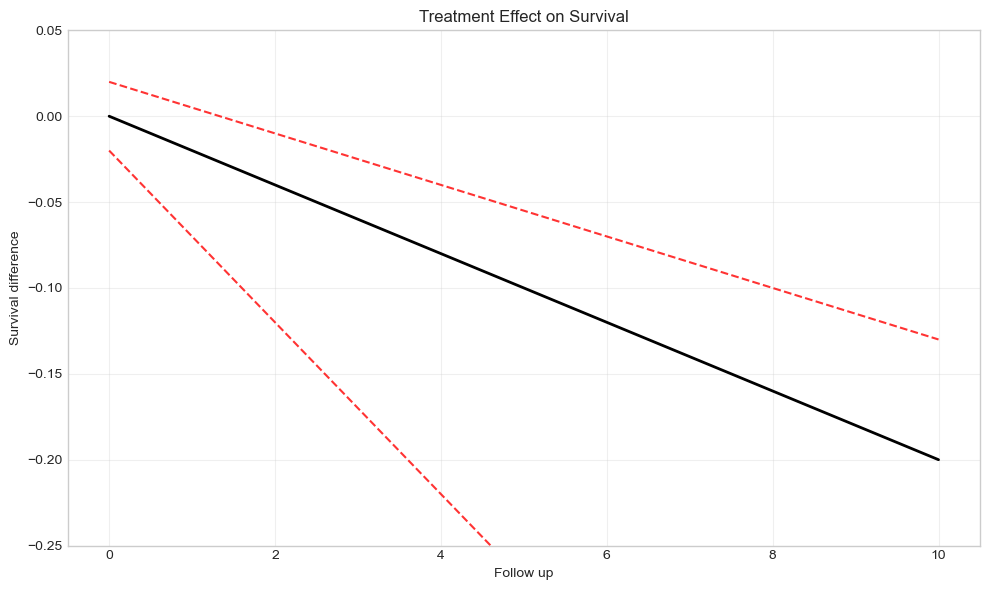

In [445]:
if __name__ == "__main__":
    # Load data
    data_censored = pd.read_csv("data/data_censored.csv")
    
    # Create trial sequence objects
    trial_pp = trial_sequence(estimand="PP")  # Per-protocol
    trial_itt = trial_sequence(estimand="ITT")  # Intention-to-treat
    
    # Create directories
    trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
    os.makedirs(trial_pp_dir, exist_ok=True)
    
    trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
    os.makedirs(trial_itt_dir, exist_ok=True)
    
    # Set data for both trial sequences
    trial_pp = trial_pp.set_data(
        data=data_censored,
        id="id",
        period="period",
        treatment="treatment",
        outcome="outcome",
        eligible="eligible"
    )
    
    trial_itt = trial_itt.set_data(
        data=data_censored,
        id="id",
        period="period",
        treatment="treatment",
        outcome="outcome",
        eligible="eligible"
    )
    
    # Set switch weight models
    trial_pp = trial_pp.set_switch_weight_model(
        numerator="~ age",
        denominator="~ age + x1 + x3",
        model_fitter=stats_glm_logit(save_path=os.path.join(trial_pp_dir, "switch_models"))
    )
    
    print(trial_pp)
    # Set censor weight models
    trial_pp = trial_pp.set_censor_weight_model(
        censor_event="censored",
        numerator="~ x2",
        denominator="~ x2 + x1",
        pool_models="none",
        model_fitter=stats_glm_logit(save_path=os.path.join(trial_pp_dir, "switch_models"))
    )
    
    trial_itt = trial_itt.set_censor_weight_model(
        censor_event="censored",
        numerator="~ x2",
        denominator="~ x2 + x1",
        pool_models="numerator",
        model_fitter=stats_glm_logit(save_path=os.path.join(trial_itt_dir, "switch_models"))
    )
    
    # Calculate weights
    trial_pp = trial_pp.calculate_weights()
    trial_itt = trial_itt.calculate_weights()
    
    # Show weight models
    show_weight_models(trial_itt)
    show_weight_models(trial_pp)
    
    # Set outcome models
    trial_pp = trial_pp.set_outcome_model()
    trial_itt = trial_itt.set_outcome_model(adjustment_terms="~ x2")
    
    # Set expansion options
    trial_pp = trial_pp.set_expansion_options(
        output=save_to_datatable(),
        chunk_size=500
    )
    
    trial_itt = trial_itt.set_expansion_options(
        output=save_to_datatable(),
        chunk_size=500
    )
    
    # Expand trials
    trial_pp = trial_pp.expand_trials()
    trial_itt = trial_itt.expand_trials()
    
    # Load expanded data
    trial_itt = trial_itt.load_expanded_data(seed=1234, p_control=0.5)

    # Merge censor weights with expansion data
    if trial_itt.censor_weights is not None:
        trial_itt.expansion = pd.merge(
            trial_itt.expansion,
            trial_itt.censor_weights,
            on=[trial_itt.id_col, trial_itt.period_col],
            how='left'
        )
        # Rename weight column to censor_weight
        trial_itt.expansion = trial_itt.expansion.rename(columns={'weight': 'censor_weight'})
        trial_itt.expansion['censor_weight'] = trial_itt.expansion['censor_weight'].fillna(1.0)

        # Now winsorize the weights
        trial_itt.expansion['censor_weight'] = np.minimum(
            trial_itt.expansion['censor_weight'],
            np.quantile(trial_itt.expansion['censor_weight'], 0.99)
        )

    # Fit MSM with the weights
    trial_itt = trial_itt.fit_msm(weight_cols=["censor_weight", "sample_weight"])
    
    # Prepare the prediction data
    prediction_data = outcome_data(trial_itt)
    prediction_data = prediction_data[prediction_data['trial_period'] == 1]

    # Add the 'const' column with value 1
    prediction_data['const'] = 1

    # Now call predict
    preds = trial_itt.predict(
        newdata=prediction_data,
        predict_times=list(range(11)),
        type="survival"
    )

    plt.figure(figsize=(10, 6))

    # Plot confidence intervals (red dashed lines)
    plt.plot(preds['difference']['followup_time'], 
            preds['difference']['97.5%'], 
            'r--', 
            alpha=0.8)
    plt.plot(preds['difference']['followup_time'], 
            preds['difference']['2.5%'], 
            'r--', 
            alpha=0.8)

    # Plot main line (solid blue)
    plt.plot(preds['difference']['followup_time'], 
            preds['difference']['survival_diff'], 
            color='black', 
            linewidth=2)

    # Set axis labels and title
    plt.xlabel('Follow up')
    plt.ylabel('Survival difference')
    plt.title('Treatment Effect on Survival')

    plt.ylim(-0.25, 0.05)

    # Add grid
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ClusterAnalysis Documentation

## Overview
The `ClusterAnalysis` class is designed to perform clustering on patient data, using K-Means and PCA for visualization. The class includes methods for determining optimal clusters, fitting the model, making predictions, visualizing clusters, and analyzing cluster characteristics and treatment effects.

## Class Definition
```python
class ClusterAnalysis:
```
### Parameters:
- `n_clusters` (int, default=3): Number of clusters for K-Means.
- `features` (list, default=None): List of feature names used for clustering.
- `random_state` (int, default=42): Random seed for reproducibility.

### Attributes:
- `scaler`: StandardScaler instance for normalizing data.
- `kmeans`: KMeans model instance (initialized during fitting).
- `pca`: PCA instance for dimensionality reduction.

---

## Methods

### `determine_optimal_clusters(data, max_clusters=10)`
Determines the optimal number of clusters using the Elbow Method and Silhouette Score.

#### Parameters:
- `data` (DataFrame): Input dataset containing the features.
- `max_clusters` (int, default=10): Maximum number of clusters to evaluate.

#### Returns:
- Dictionary containing inertia values, silhouette scores, and corresponding k values.

#### Visualization:
- Plots the Elbow Method and Silhouette Analysis graphs.

---

### `fit(data, baseline_only=True)`
Fits the K-Means model on the provided dataset and assigns cluster labels.

#### Parameters:
- `data` (DataFrame): The dataset to fit the model on.
- `baseline_only` (bool, default=True): If True, only considers baseline period (where `period == 0`).

#### Returns:
- The fitted `ClusterAnalysis` instance.

---

### `predict(data)`
Predicts cluster labels for new data points.

#### Parameters:
- `data` (DataFrame): Input dataset containing the features.

#### Returns:
- Array of predicted cluster labels.

---

### `visualize_clusters(data, baseline_only=True)`
Visualizes the clusters using PCA.

#### Parameters:
- `data` (DataFrame): Dataset to visualize.
- `baseline_only` (bool, default=True): If True, only visualizes baseline data.

#### Visualization:
- Scatter plot of clusters in PCA space with centroids.

---

### `analyze_cluster_characteristics(data, baseline_only=True)`
Analyzes the characteristics of each cluster.

#### Parameters:
- `data` (DataFrame): Input dataset with cluster assignments.
- `baseline_only` (bool, default=True): If True, only considers baseline period.

#### Returns:
- DataFrame summarizing the mean feature values per cluster.

#### Visualization:
- Heatmap of feature means per cluster.
- Boxplots of feature distributions across clusters.

---

### `analyze_treatment_effect_by_cluster(trial_sequence, predict_times=None)`
Analyzes treatment effects within each cluster over time.

#### Parameters:
- `trial_sequence` (object): Trial sequence containing treatment expansion data.
- `predict_times` (list, default=None): List of time points for prediction.

#### Returns:
- Dictionary of predicted treatment effects per cluster.

#### Visualization:
- Line plots showing survival differences over follow-up time.

---

## Usage Example
```python
# Initialize clustering object
cluster_analysis = ClusterAnalysis(n_clusters=4, features=['age', 'bp', 'cholesterol'])

# Determine optimal clusters
optimal_clusters = cluster_analysis.determine_optimal_clusters(data)

# Fit the model
cluster_analysis.fit(data)

# Predict clusters
predictions = cluster_analysis.predict(new_data)

# Visualize clusters
cluster_analysis.visualize_clusters(data)

# Analyze cluster characteristics
summary = cluster_analysis.analyze_cluster_characteristics(data)

# Analyze treatment effects
results = cluster_analysis.analyze_treatment_effect_by_cluster(trial_sequence)
```


In [446]:
class ClusterAnalysis:
    def __init__(self, n_clusters=3, features=None, random_state=42):
        self.n_clusters = n_clusters
        self.features = features
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.kmeans = None
        self.pca = PCA(n_components=2)

    def determine_optimal_clusters(self, data, max_clusters=10):
        if self.features is None:
            raise ValueError("Features must be specified before determining optimal clusters")
        
        features_df = data[self.features].copy().fillna(data[self.features].mean())
        X = self.scaler.fit_transform(features_df)
        inertia_values = []
        silhouette_values = []
        
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state, n_init=10)
            kmeans.fit(X)
            inertia_values.append(kmeans.inertia_)
            silhouette_values.append(silhouette_score(X, kmeans.labels_))
        
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(2, max_clusters + 1), inertia_values, 'bo-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method')
        
        plt.subplot(1, 2, 2)
        plt.plot(range(2, max_clusters + 1), silhouette_values, 'ro-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Analysis')
        plt.show()
        
        return {'inertia': inertia_values, 'silhouette': silhouette_values, 'k_values': list(range(2, max_clusters + 1))}

    def fit(self, data, baseline_only=True):
        if self.features is None:
            raise ValueError("Features must be specified before fitting")
        
        fitting_data = data[data['period'] == 0] if baseline_only else data
        features_df = fitting_data[self.features].copy().fillna(fitting_data[self.features].mean())
        X = self.scaler.fit_transform(features_df)
        
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10)
        self.kmeans.fit(X)
        fitting_data['cluster'] = self.kmeans.labels_
        self.pca.fit(X)
        
        return self

    def predict(self, data):
        if self.kmeans is None:
            raise ValueError("Model must be fitted before prediction")
        
        features_df = data[self.features].copy().fillna(data[self.features].mean())
        X = self.scaler.transform(features_df)
        return self.kmeans.predict(X)

    def visualize_clusters(self, data, baseline_only=True):
        if self.kmeans is None:
            raise ValueError("Model must be fitted before visualization")
        
        vis_data = data[data['period'] == 0] if baseline_only else data
        features_df = vis_data[self.features].copy().fillna(vis_data[self.features].mean())
        X_pca = self.pca.transform(self.scaler.transform(features_df))
        
        pca_df = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1], 'Cluster': vis_data['cluster']})
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
        centroids_pca = self.pca.transform(self.kmeans.cluster_centers_)
        plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, marker='X', color='red', edgecolor='black', label='Centroids')
        plt.title('Patient Clusters Visualization using PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend(title='Cluster')
        plt.show()

    def analyze_cluster_characteristics(self, data, baseline_only=True):
        if 'cluster' not in data.columns:
            raise ValueError("Data must contain cluster assignments")
        
        analysis_data = data[data['period'] == 0] if baseline_only else data
        cluster_summary = analysis_data.groupby('cluster')[self.features].mean()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
        plt.title('Cluster Characteristics: Feature Means by Cluster')
        plt.show()
        
        n_features = len(self.features)
        plt.figure(figsize=(15, (n_features + 1) // 2 * 5))
        for i, feature in enumerate(self.features):
            plt.subplot((n_features + 1) // 2, 2, i + 1)
            sns.boxplot(x='cluster', y=feature, data=analysis_data)
            plt.title(f'Distribution of {feature} by Cluster')
        plt.tight_layout()
        plt.show()
        
        return cluster_summary
    
    def analyze_treatment_effect_by_cluster(self, trial_sequence, predict_times=None):
        """Analyze treatment effects within each cluster."""
        if predict_times is None:
            predict_times = list(range(11))
            
        # Ensure expansion data exists
        if trial_sequence.expansion is None:
            raise ValueError("TrialSequence expansion data must be available")
            
        # Add clusters to expansion data if not present
        if 'cluster' not in trial_sequence.expansion.columns:
            baseline_data = trial_sequence.data[trial_sequence.data['period'] == 0]
            baseline_clusters = pd.DataFrame({
                'id': baseline_data['id'],
                'cluster': baseline_data['cluster']
            })
            
            trial_sequence.expansion = pd.merge(
                trial_sequence.expansion, 
                baseline_clusters,
                on=trial_sequence.id_col,
                how='left'
            )
            
        # Calculate effects by cluster
        results_by_cluster = {}
        all_clusters = sorted(trial_sequence.expansion['cluster'].unique())
        
        plt.figure(figsize=(14, 8))
        
        for cluster in all_clusters:
            cluster_data = trial_sequence.expansion[
                (trial_sequence.expansion['cluster'] == cluster) & 
                (trial_sequence.expansion['trial_period'] == 1)
            ].copy()
            
            if len(cluster_data) == 0:
                continue
            
            try:
                cluster_pred = trial_sequence.predict(
                    newdata=cluster_data,
                    predict_times=predict_times,
                    type="survival"
                )
                
                results_by_cluster[f'Cluster {cluster}'] = cluster_pred
                
                plt.plot(
                    cluster_pred['difference']['followup_time'], 
                    cluster_pred['difference']['survival_diff'],
                    label=f'Cluster {cluster}', 
                    linewidth=2
                )
            except Exception as e:
                print(f"Error predicting for cluster {cluster}: {e}")
        
        plt.axhline(0, color='black', linestyle='--')
        plt.xlabel('Follow-up Time', fontsize=12)
        plt.ylabel('Survival Difference', fontsize=12)
        plt.title('Treatment Effect by Cluster', fontsize=15)
        plt.legend(title='Cluster')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return results_by_cluster

Number of patients at baseline: 89


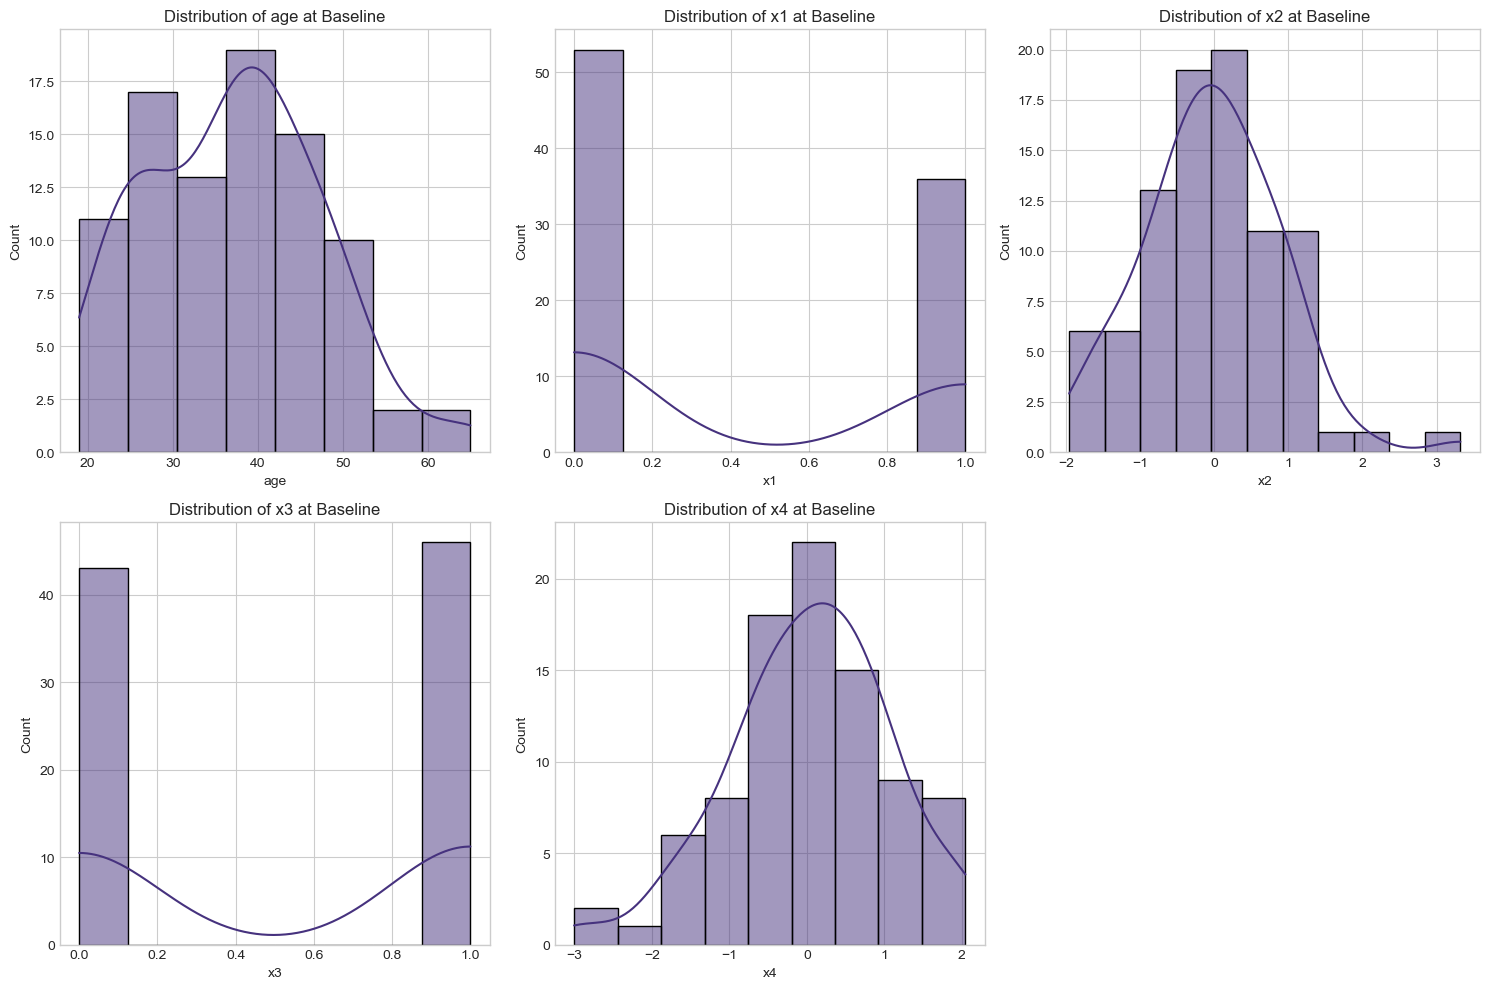

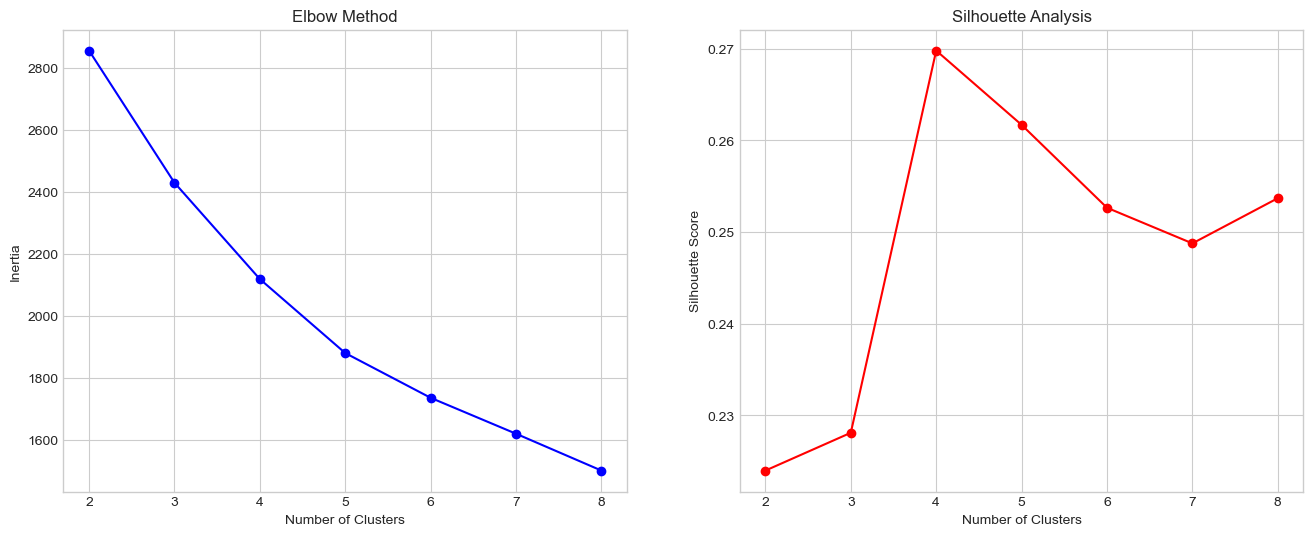

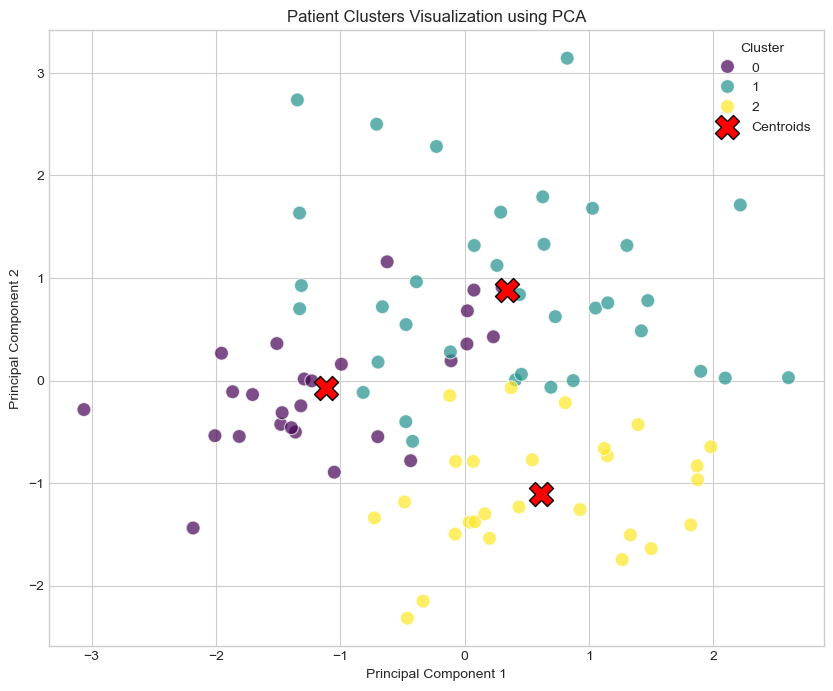

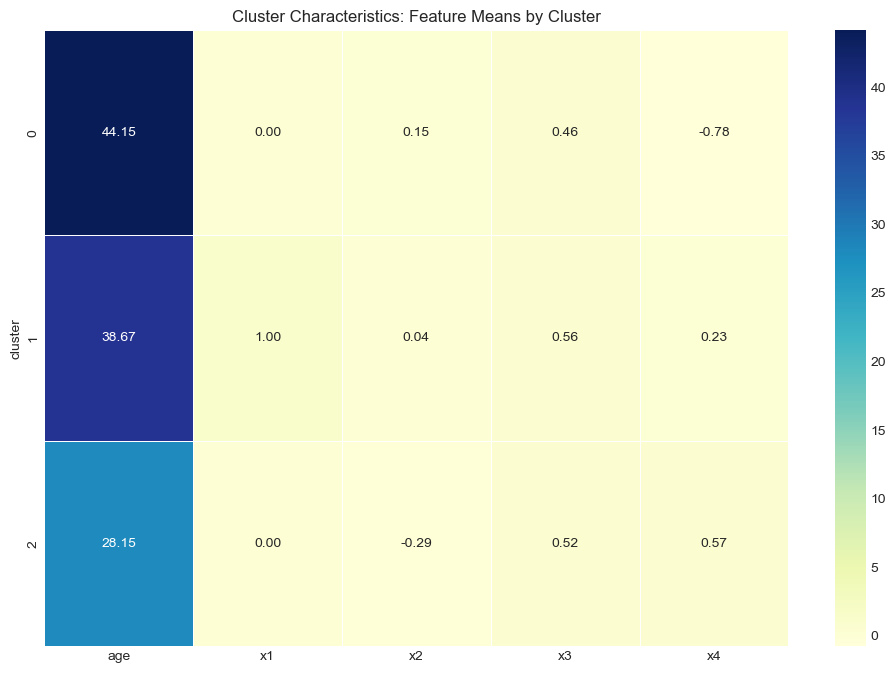

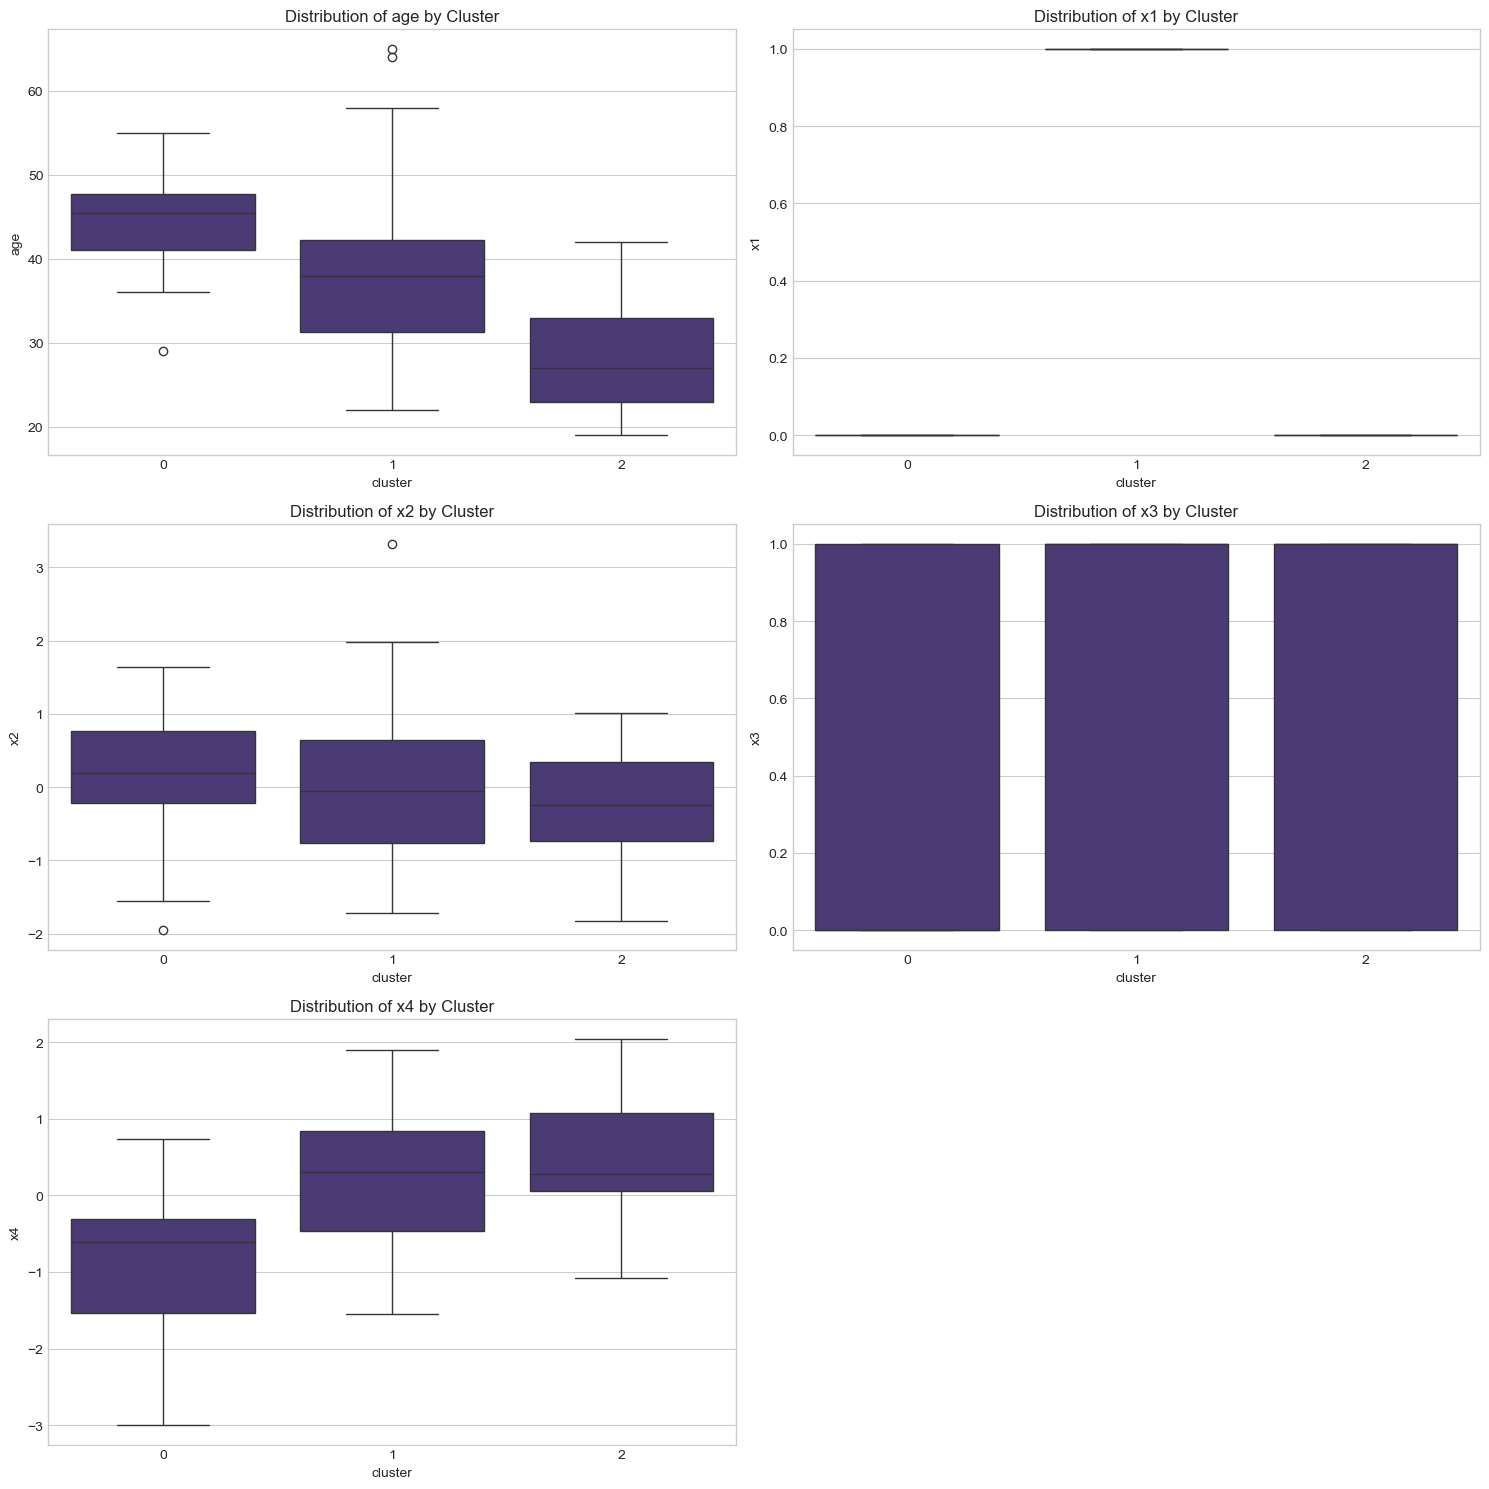


Cluster Characteristics Summary:


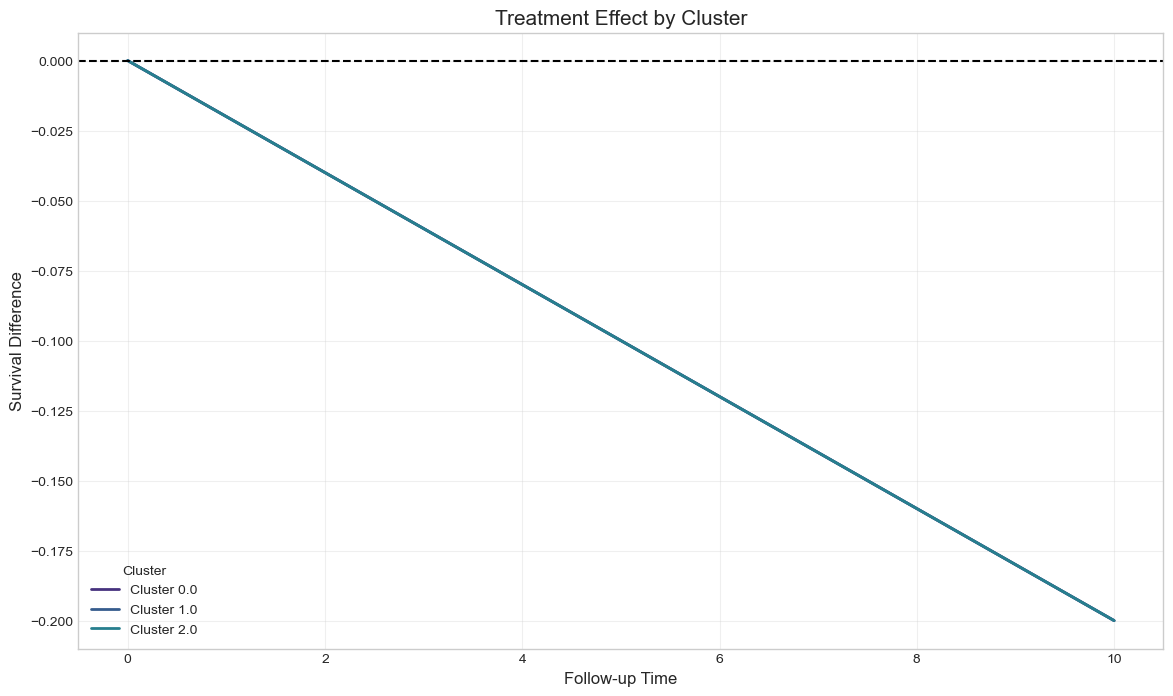

    id  period  treatment   x1        x2   x3        x4   age     age_s  \
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
1  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
2  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
3  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
4  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   

   outcome  censored  eligible  cluster  trial_period  assigned_treatment  \
0      0.0       0.0       1.0      1.0           1.0                   1   
1      0.0       0.0       1.0      1.0           2.0                   0   
2      0.0       0.0       1.0      1.0           3.0                   0   
3      0.0       0.0       1.0      1.0           4.0                   0   
4      0.0       0.0       1.0      1.0           5.0                   1   

   eligible_t  censor_weight  
0           1       1.725487  
1           0       1.72

In [447]:
# Explore the baseline data (period = 0)
baseline_data = data_censored[data_censored['period'] == 0]
print(f"Number of patients at baseline: {len(baseline_data)}")

# Distribution of baseline characteristics
plt.figure(figsize=(15, 10))
features = ['age', 'x1', 'x2', 'x3', 'x4']

for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(baseline_data[feature], kde=True)
    plt.title(f'Distribution of {feature} at Baseline')
    
plt.tight_layout()
plt.show()

# Define features for clustering
cluster_features = ['age', 'x1', 'x2', 'x3', 'x4']

# Initialize the ClusterAnalysis object
cluster_analysis = ClusterAnalysis(features=cluster_features)

# Determine optimal number of clusters
cluster_results = cluster_analysis.determine_optimal_clusters(data_censored, max_clusters=8)

# Initialize TrialSequence
trial = TrialSequence(estimand="ITT")

# Set data
trial.set_data(
    data=data_censored,
    id="id",
    period="period",
    treatment="treatment",
    outcome="outcome",
    eligible="eligible"
)

# Set up censoring weight model
trial.set_censor_weight_model(
    censor_event="censored",
    numerator="~ age + x3",
    denominator="~ age + x1 + x2 + x3 + x4",
    pool_models="none",
    model_fitter=sm.Logit
)

# Calculate weights
trial.calculate_weights()

# Initialize the clustering with 3 clusters
cluster_analysis = ClusterAnalysis(
    n_clusters=3,
    features=cluster_features,
    random_state=42
)

# Fit clustering on baseline data only
cluster_analysis.fit(trial.data, baseline_only=True)

# Add cluster assignments back to original data
baseline_data = trial.data[trial.data['period'] == 0].copy()
baseline_data['cluster'] = cluster_analysis.kmeans.labels_

# Create mapping from ID to cluster
id_to_cluster = dict(zip(baseline_data['id'], baseline_data['cluster']))

# Assign cluster to all rows based on ID
trial.data['cluster'] = trial.data['id'].map(id_to_cluster)

# Visualize the clusters
cluster_analysis.visualize_clusters(trial.data)

# Analyze cluster characteristics
cluster_summary = cluster_analysis.analyze_cluster_characteristics(trial.data)
print("\nCluster Characteristics Summary:")
cluster_summary

# Set outcome model with cluster as a covariate
trial.set_outcome_model(adjustment_terms="~ age + x3 + cluster")

# Set expansion options
trial.set_expansion_options(chunk_size=500)

# Expand trials
trial.expand_trials()

# Load expanded data
trial.load_expanded_data(seed=42, p_control=0.5)

# When fitting the MSM, use the appropriate weight columns
if trial.estimand == "PP":
    # For PP analysis, use both censor and switch weights
    trial.fit_msm(weight_cols=["censor_weight", "switch_weight"])
else:
    # For ITT analysis, use only censor weights
    trial.fit_msm(weight_cols=["censor_weight"])

# Analyze treatment effect heterogeneity
treatment_effects = cluster_analysis.analyze_treatment_effect_by_cluster(
    trial_sequence=trial,
    predict_times=list(range(11))
)

print(trial.expansion.head())
print(trial.expansion['trial_period'].unique())
print(trial.expansion['cluster'].unique())
